# 5. The Value of Domain Knowledge: Incorporating Geological Features
Compiled by [Morgan Williams](mailto:morgan.williams@csiro.au) for C3DIS 2018 

Thus far, much of the content has concerned more applied chemistry and statistics. Here we touch on some valuable aspects of domain-specific knowledge relevant for geochemical data analysis. Additionally, we examine the potential for data to be used as a validation method for existing domain methods and knowledge.

### Classification

*"All science is either physics or stamp collecting"* **Ernest Rutherford**

Geologists, like most other scientists which conduct observation-based investigations, have a habit of 'stamp collecting'. Methods to classify rocks provide geologists with a vocabulary with which to discuss and focus their investigations, but models developed in the past are rarely subjected to continued testing and refinement. Geological samples and derived geochemical data are commonly stored with pre-derived classifications. Here we derive these from their models, and compare i) the quality of database classification information, and ii) the potential relevance of historical classification models in an era which is no longer data-limited.

Modern databases provide a foundation for i) testing historical classification schemes and ii) implementing new classification schemes based on inherent data relationships and statistical divisions.

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext memory_profiler

In [15]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint

sys.path.insert(0, './src')
from compositions import *
from geochem import *
from classification import Geochemistry
from alteration import *
from datasource import load_df
from normalisation import *
from plotting_tools import *

In [6]:
%%memit
df = load_df('EarthChemData.pkl', dense=True)

peak memory: 1530.32 MiB, increment: 1417.10 MiB


In [7]:
cm = Geochemistry.TAS()
classnames = cm.clsf.fclasses + ['none']
df.TotalAlkali = df.Na2O + df.K2O
df['TAS'] = cm.classify(df).astype('category')
df['TAScolors'] = df['TAS'].map(lambda x: classnames.index(x)) # Use the index in the list for a simple colormap
df['TASRock'] = df['TAS'].map(lambda x: cm.clsf.fields.get(x,{'names': ['N/A']}).get('names')[0])

From here we can assess a range of questions regarding the data quality, and potentially the quality of classification methods.

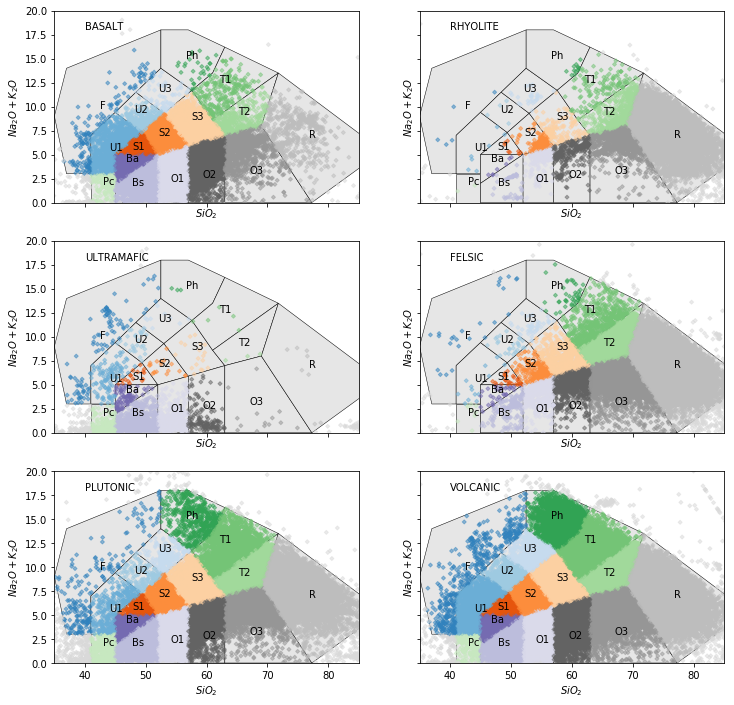

In [8]:
fig, ax = plt.subplots(3, 2, figsize=(12, 12), sharex=True, sharey=True)
ax=ax.flat
for a in ax:
    a.set_ylabel('$Na_2O + K_2O$')
    a.set_xlabel('$SiO_2$')
    cm.add_to_axes(a, facecolor='0.9', edgecolor='k', linewidth=0.5, zorder=-1)

TAS_filter = (~pd.isnull(df.SiO2)) & (~pd.isnull(df.TotalAlkali)) & (df.loc[:, 'Material'] == 'IGNEOUS')
filters = []
for rockname in ['BASALT', 'RHYOLITE']:
    filters.append((rockname, TAS_filter & (df.loc[:, 'RockName'] == rockname)))
    
for composition in ['ULTRAMAFIC', 'FELSIC']:
    filters.append((composition, TAS_filter & (df.loc[:, 'Composition'] == composition)))
    
for rocktype in ['PLUTONIC', 'VOLCANIC']:
    filters.append((rocktype, TAS_filter & (df.loc[:, 'Type'] == rocktype))) 
    
for ix, (name, filt) in enumerate(filters):
    subdf = df.loc[filt, :]
    ax[ix].annotate(name, xy=(0.1, 0.9), ha='left', xycoords=ax[ix].transAxes)
    ax[ix].scatter(subdf.SiO2,
                   subdf.TotalAlkali,
                   c=subdf.TAScolors,
                   alpha=0.5, marker='D', s=8, cmap='tab20c')

### Give me a Map: Incorporating Reference Frames

Communicating the significance of data in a broader context requires some reference frame. This is a feature commonly addressed throughout all scientific disciplines, and geologists in general do this relatively well.

The simplest case of such a reference frame in geochemistry is the composition of a known reference material - which could be a mineral, a particular rock type or our estimate for the average composition of the solar system. While such reference frames are present throughout the literature, they are rarely baked into analysis tools, and the basic information required to reproduce them is commonly required to be reconstructed manually. Here we attempt to begin construction of a few reference frames for different purposes.

#### Normalisation

Normalisation is one technique used to provide reference frames in geochemistry. In some cases, it can be used to give an indication of relative change - for example the addition or removal of material from a rock (e.g. as a melt).

In [81]:
refdb = build_reference_db(Path("./data/refcomp"), encoding='cp1252')
CH = RefComp(Path("./data/refcomp/CH_PalmeONeill2014.csv"), encoding='cp1252')

n = 10
dat = pd.DataFrame({'Cu': (np.random.randn(n) * 1 + 5),
                   'Mn': np.linspace(1, 10, n),
                   'Fe': 0.98 ** np.linspace(0, 20, n),
                   'Ni': np.exp(np.linspace(10, 90, n))
                   })

print('Before normalisation:')
print(dat.loc[:3, :])
print(f'Normalising to: {CH}')
print(CH[dat.columns])
print('After normalisation:')
print(CH.normalize(dat).loc[:3, :])

Before normalisation:
         Cu   Mn        Fe            Ni
0  4.798514  1.0  1.000000  2.202647e+04
1  4.030390  2.0  0.956098  1.597130e+08
2  5.460658  3.0  0.914123  1.158072e+12
3  3.578959  4.0  0.873991  8.397132e+15
Normalising to: Model of Chondrite (Palme2014)
     value  unc_2sigma units
Cu     133    37.24000   ppm
Mn    1916   229.92000   ppm
Fe  186600     1.49280   ppm
Ni   10910     0.15274   ppm
After normalisation:
         Cu        Mn            Fe            Ni
0  0.036079  0.000522  5.359057e-10  2.018924e-04
1  0.030304  0.001044  5.123783e-10  1.463914e+00
2  0.041058  0.001566  4.898839e-10  1.061478e+04
3  0.026909  0.002088  4.683770e-10  7.696730e+07


Below we use a few reference models to illustrate a common use of normalisation in visualisation - spiderplots. We compare two models of depleted mantle composition as absolute abundances and as abundances relative to a reference composition - chondritic meteorites (close to our estimate of the overall solar system composition). 

The 'zig-zag' pattern of absolute abundance diagram highlights the [Oddo-Harkins rule ](https://en.wikipedia.org/wiki/Oddo%E2%80%93Harkins_rule), an effect remnant from the formation of the solar system. This isn't particularly relevant information for events which have happened since, so we smooth it out by normalising to the average composition of chondritic meteorites to better visualise relevant geological information. 

In a sense, this normalisation allow us to visualise 'things which have happened since planet formation started' using the relative enrichments and depletions relative an approximate planetary starting material.

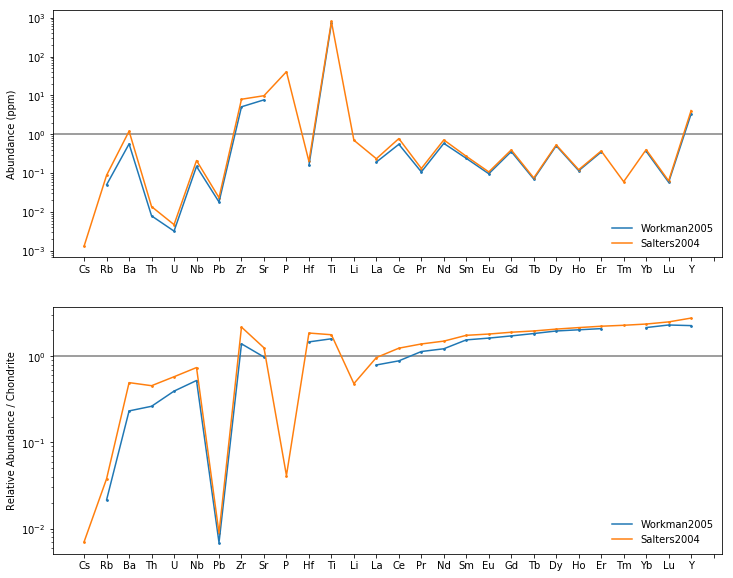

In [69]:
elements = ['Cs','Rb','Ba','Th','U','Nb','Pb','Zr','Sr','P','Hf','Ti','Li',
            'La','Ce','Pr','Nd','Sm','Eu','Gd','Tb','Dy','Ho','Er','Tm','Yb','Lu',
            'Y',#'Ca','V','Sc','Mn','Mg','Cr','Ni'
           ]

fig, ax = plt.subplots(2, 1, figsize=(12, 10))
ax[0].set_ylabel('Abundance (ppm)')
ax[1].set_ylabel('Relative Abundance / Chondrite')
for dmm in [refdb['DMM_WH'], refdb['DM_SS']]:
    df1 = pd.Series({el: dmm[el].value for el in elements}) # Depleted mantle pattern
    TE_spiderplot(ax[0], df1, elements, label=dmm.Reference)
    df2 = pd.Series({el: dmm[el].value/CH[el].value for el in elements}) # Normalised depleted mantle pattern
    TE_spiderplot(ax[1], df2, elements, label=dmm.Reference)

for a in ax:
    a.set_xticks(np.arange(len(elements)+1))
    a.set_xticklabels(elements)
    a.axhline(1, color='k', zorder=-1, alpha=0.5)
    a.set_yscale('log')
    a.legend(frameon=False, loc='lower right', bbox_to_anchor=(1,0))

#### Reference Compositions

### Beyond Data QA: Geochemistry QA

Controlling data quality is the first step, but for various reasons specific samples can be unsuitable for investigating specific geochemical features or processes. Here we note a group of simple alteration proxies which can be used to create data-derived features for use in data filtering/classification. These proxies are intended to encompase the effects of chemical alteration - most are tied to specific mineralogical weathering processes. As a first pass we can visualise the distribution of these proxies across the database samples.

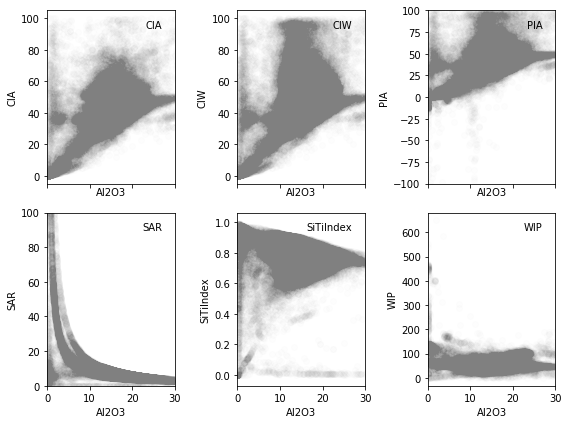

In [7]:
alteration_index_functions = [CIA, CIW, PIA, SAR, SiTiIndex, WIP]
lenfs = len(alteration_index_functions)
plotswide=3
unit = 2
fig, ax = plt.subplots(lenfs%plotswide+lenfs//plotswide, plotswide,
                       figsize=((1+plotswide) * unit, (1 + lenfs//plotswide) * unit),
                       sharex=True)
ax = ax.flat
xvar = 'Al2O3'
filt = (df.Material == 'IGNEOUS') & (~pd.isnull(df.loc[:, xvar]))
major_components = [i for i in df.columns if i in common_oxides(output='str')]
for ix, f in enumerate(alteration_index_functions):
    fname = f.__name__
    if not fname in df.columns:
        df[fname] = f(to_molecular(df.loc[filt, major_components]))
    
    ax[ix].annotate(fname, xy=(0.9, 0.9), ha='right', xycoords=ax[ix].transAxes)
    ax[ix].scatter(df.loc[filt, xvar], df.loc[filt, fname], alpha=0.01, color='0.5')
    ax[ix].set_xlabel(xvar)
    ax[ix].set_ylabel(fname)
    
ax[2].set_ylim((-100, 100))
ax[3].set_ylim((0, 100))
ax[0].set_xlim((0, 30))
plt.tight_layout()